In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import iris
import iris.plot as iplt
import iris.quickplot as qplt

In [3]:
import netCDF4
import numpy as np
import pandas as pd
import shapefile
from mpl_toolkits.basemap import Basemap

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

# 1. Load in data - daily max temperature (1995.1.1 - 2015.6.30)

In [5]:
max_temp = iris.load('tx_0.25deg_reg_1995-2015_v12.0.nc')

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\iris\fileformats\cf.py:1139: UserWarning: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warnings.warn(msg)


## 1.1 check data structure

In [6]:
print(max_temp)

0: air_temperature / (Celsius)         (time: 7486; latitude: 201; longitude: 464)


In [7]:
air_temperature = max_temp[0]

In [8]:
print(air_temperature)

air_temperature / (Celsius)         (time: 7486; latitude: 201; longitude: 464)
     Dimension coordinates:
          time                           x               -               -
          latitude                       -               x               -
          longitude                      -               -               x
     Attributes:
          Conventions: CF-1.4
          Ensembles_ECAD: 12.0
          NCO: 4.4.5
          References: http://www.ecad.eu\nhttp://www.ecad.eu/download/ensembles/ensembles.ph...
          history: Tue Oct 27 14:30:12 2015: ncks -d time,16436,23921 tx_0.25deg_regular.nc...


## 1.2 plot the first day air temperature for a spatial idea

In [9]:
temperature_1d = air_temperature[0,:]

In [10]:
air_temperature.coord('latitude').guess_bounds()
air_temperature.coord('longitude').guess_bounds()

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\iris\coords.py:802: UserWarning: Coordinate u'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\iris\coords.py:802: UserWarning: Coordinate u'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\matplotlib\artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


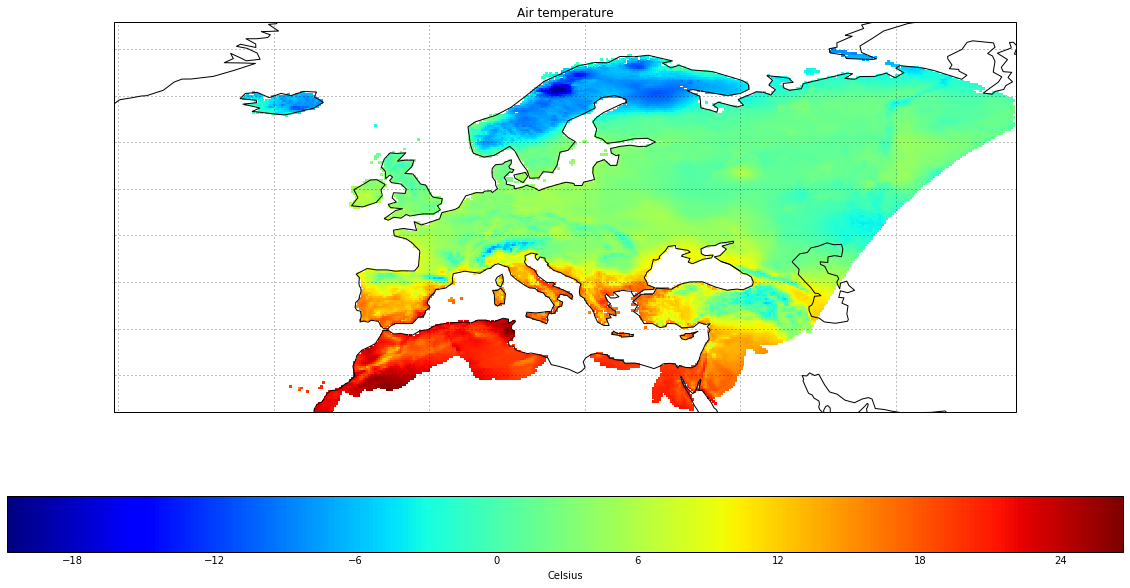

In [11]:
plt.figure(figsize=(20, 10))
qplt.pcolormesh(temperature_1d)
ax = plt.gca()
ax.coastlines()
ax.gridlines()

## 1.3 focusing on Switzerland since here we are

In [12]:
CH_outline = shapefile.Reader('CHE_adm0')

### Tried to use Switzerland's country outline for downscaling, but there is a bug, i.e. geometry from shapely doesn't have attribute 'bounds', it should be 'bbox'. 

from iris.analysis.geometry import geometry_area_weights
geometry_area_weights(air_temperature, CH_outline, normalize=True)

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-29-a0410eed76be> in <module>()
      1 from iris.analysis.geometry import geometry_area_weights
----> 2 geometry_area_weights(air_temperature, CH_outline, normalize=True)

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\iris\analysis\geometry.pyc in geometry_area_weights(cube, geometry, normalize)
    183     # extract smallest subcube containing geometry
    184     shape = cube.shape
--> 185     extraction_results = _extract_relevant_cube_slice(cube, geometry)
    186 
    187     # test if there is overlap between cube and geometry

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\iris\analysis\geometry.pyc in _extract_relevant_cube_slice(cube, geometry)
     81 
     82     # find indices of coordinate bounds to fully cover geometry
---> 83     x_min_geom, y_min_geom, x_max_geom, y_max_geom = geometry.bounds
     84     try:
     85         x_min_ix = np.where(x_bounds_lower <= x_min_geom)[0]

AttributeError: Reader instance has no attribute 'bounds'

### Downscaling with bounding box of Switzerland instead.

In [13]:
llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat = CH_outline.bbox

In [14]:
CH = iris.Constraint(longitude=lambda cell: llcrnrlon < cell < urcrnrlon, 
                     latitude=lambda cell: llcrnrlat < cell < urcrnrlat )
print(CH)

Constraint(coord_values={'latitude': <function <lambda> at 0x000000001065D5F8>, 'longitude': <function <lambda> at 0x0000000006E08B38>})


(1,
 5,
 [5.956063270568848, 45.81705856323265, 0.0, 0.0],
 [10.495112419128496, 47.80848312377949, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x10961518>)

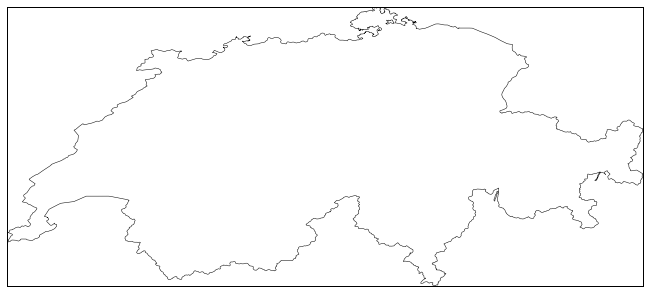

In [15]:
map = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat)
plt.figure(figsize=(20, 5))
map.readshapefile('CHE_adm0', 'CHE')

In [16]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

In [17]:
CH_outline1 = list(shpreader.Reader('CHE_adm0.shp').geometries())

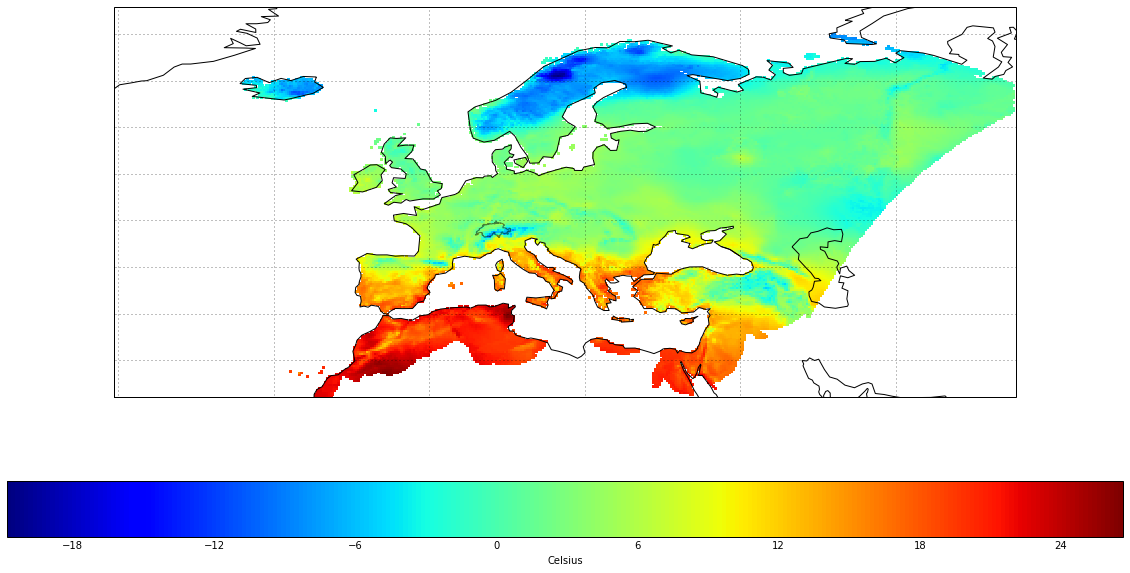

In [18]:
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
qplt.pcolormesh(temperature_1d)
ax.add_geometries(CH_outline1, ccrs.PlateCarree(), edgecolor='black', facecolor='', alpha=0.5)
plt.title('')
ax.coastlines()
ax.gridlines()

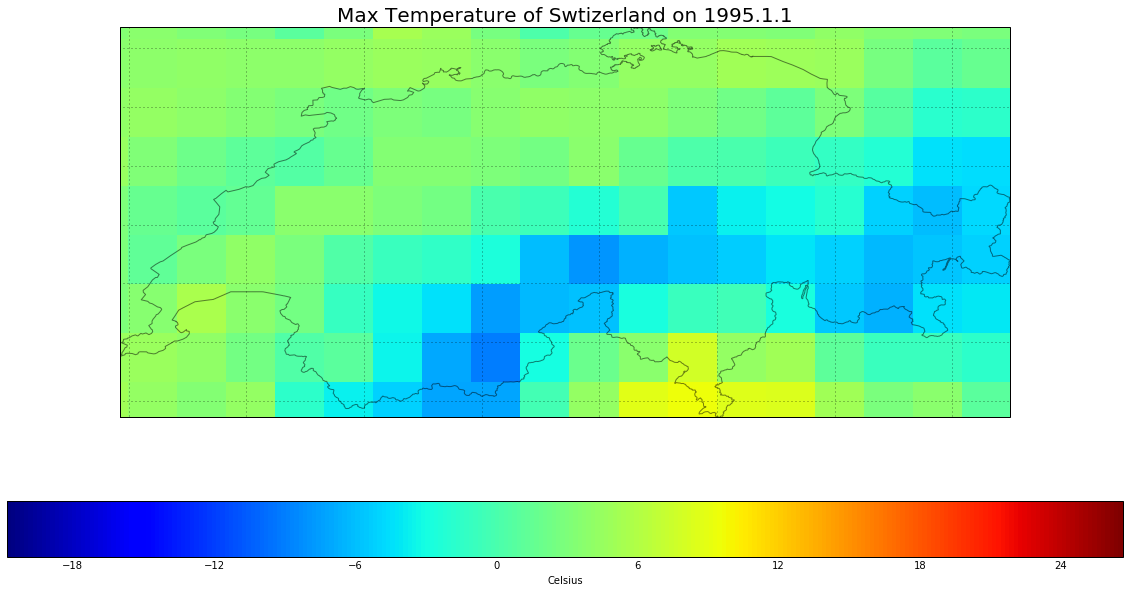

In [19]:
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
qplt.pcolormesh(temperature_1d)
ax.add_geometries(CH_outline1, ccrs.PlateCarree(), edgecolor='black', facecolor='', alpha=0.5)
plt.title('Max Temperature of Swtizerland on 1995.1.1', fontsize=20)
ax.coastlines()
ax.gridlines()
ax.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())

In [20]:
CH_temperature = air_temperature.extract(CH)

In [21]:
print(CH_temperature)

air_temperature / (Celsius)         (time: 7486; latitude: 7; longitude: 17)
     Dimension coordinates:
          time                           x               -             -
          latitude                       -               x             -
          longitude                      -               -             x
     Attributes:
          Conventions: CF-1.4
          Ensembles_ECAD: 12.0
          NCO: 4.4.5
          References: http://www.ecad.eu\nhttp://www.ecad.eu/download/ensembles/ensembles.ph...
          history: Tue Oct 27 14:30:12 2015: ncks -d time,16436,23921 tx_0.25deg_regular.nc...


## 1.4 downscaling to Switlzerland

In [22]:
CH_TS = CH_temperature.collapsed(['longitude', 'latitude'], iris.analysis.MEAN)

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\iris\cube.py:2975: UserWarning: Collapsing spatial coordinate u'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


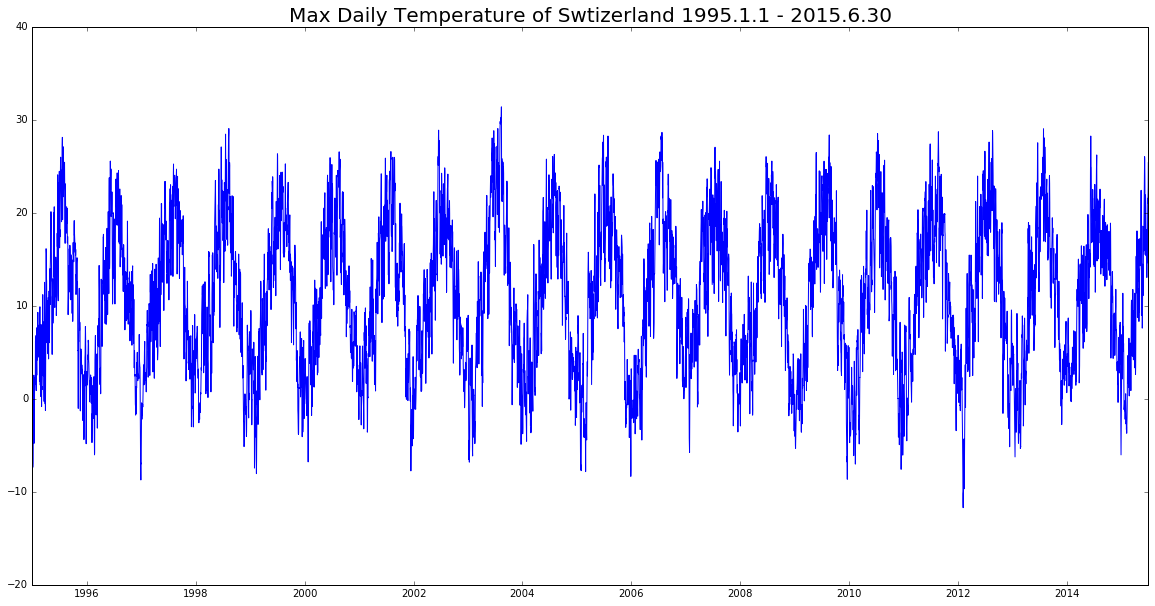

In [23]:
plt.figure(figsize=(20, 10))
iplt.plot(CH_TS)
plt.title('Max Daily Temperature of Swtizerland 1995.1.1 - 2015.6.30', fontsize=20)

# 2. Data analysis

In [24]:
iris.save(CH_TS, 'CH_maxT.nc')

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\iris\fileformats\netcdf.py:1786: UserWarning: NetCDF default saving behaviour currently assigns the outermost dimensions to unlimited. This behaviour is to be deprecated, in favour of no automatic assignment. To switch to the new behaviour, set iris.FUTURE.netcdf_no_unlimited to True.
  warnings.warn(msg)


In [25]:
ch_ts = netCDF4.Dataset('CH_maxT.nc', mode='r')

## 2.1 check data structure

In [26]:
# http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print "\t\ttype:", repr(nc_fid.variables[key].dtype)
            for ncattr in nc_fid.variables[key].ncattrs():
                print '\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr))
        except KeyError:
            print "\t\tWARNING: %s does not contain variable attributes" % key

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print "NetCDF Global Attributes:"
        for nc_attr in nc_attrs:
            print '\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print "NetCDF dimension information:"
        for dim in nc_dims:
            print "\tName:", dim 
            print "\t\tsize:", len(nc_fid.dimensions[dim])
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print "NetCDF variable information:"
        for var in nc_vars:
            if var not in nc_dims:
                print '\tName:', var
                print "\t\tdimensions:", nc_fid.variables[var].dimensions
                print "\t\tsize:", nc_fid.variables[var].size
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [27]:
nc_attrs, nc_dims, nc_vars = ncdump(ch_ts)

NetCDF Global Attributes:
	Ensembles_ECAD: u'12.0'
	NCO: u'4.4.5'
	References: u'http://www.ecad.eu\\nhttp://www.ecad.eu/download/ensembles/ensembles.php\\nhttp://www.ecad.eu/download/ensembles/Haylock_et_al_2008.pdf'
	history: u'Tue Oct 27 14:30:12 2015: ncks -d time,16436,23921 tx_0.25deg_regular.nc tx_0.25deg_reg_1995-2015_v12.0.nc'
	Conventions: u'CF-1.5'
NetCDF dimension information:
	Name: time
		size: 7486
		type: dtype('int32')
		axis: u'T'
		units: u'days since 1950-01-01 00:00'
		standard_name: u'time'
		long_name: u'Time in days'
		calendar: u'gregorian'
	Name: bnds
		size: 2
		type: 		WARNING: bnds does not contain variable attributes
NetCDF variable information:
	Name: tx
		dimensions: (u'time',)
		size: 7486
		type: dtype('float32')
		_FillValue: 1e+20
		standard_name: u'air_temperature'
		long_name: u'maximum temperature'
		units: u'Celsius'
		cell_methods: u'longitude: latitude: mean'
		coordinates: u'latitude longitude'
	Name: latitude
		dimensions: ()
		size: 1.0
		ty

In [28]:
times = ch_ts.variables['time']
time_index = netCDF4.num2date(times[:], times.units)

In [29]:
temperature = pd.DataFrame(ch_ts.variables['tx'][:], index=time_index, columns=['max_temp'])

In [30]:
temperature.head()

,max_temp
1995-01-01,0.479861
1995-01-02,-4.636667
1995-01-03,-4.647083
1995-01-04,-7.256805
1995-01-05,-6.550694


## 2.2 Check stationarity

- A time seriies is stationary if its statistical properties such as mean, variance remain constant over time. From the previous time series plot, it seems that there isn't an overall increasing trend in the data, though seasonal variations are obvious.
- Following, I'm going to check stationarity 
 1. by plotting rolling statistics (moving average and moving standard deviation) and 
 2. with Dickey-Fuller Test: the null hypothesis is that the time series is non-stationary.

In [31]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=365)
    rolstd = pd.rolling_std(timeseries, window=365)

    #Plot rolling statistics:
    plt.figure(figsize=(20, 10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize=20)

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=365,center=False).mean()
C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=365,center=False).std()


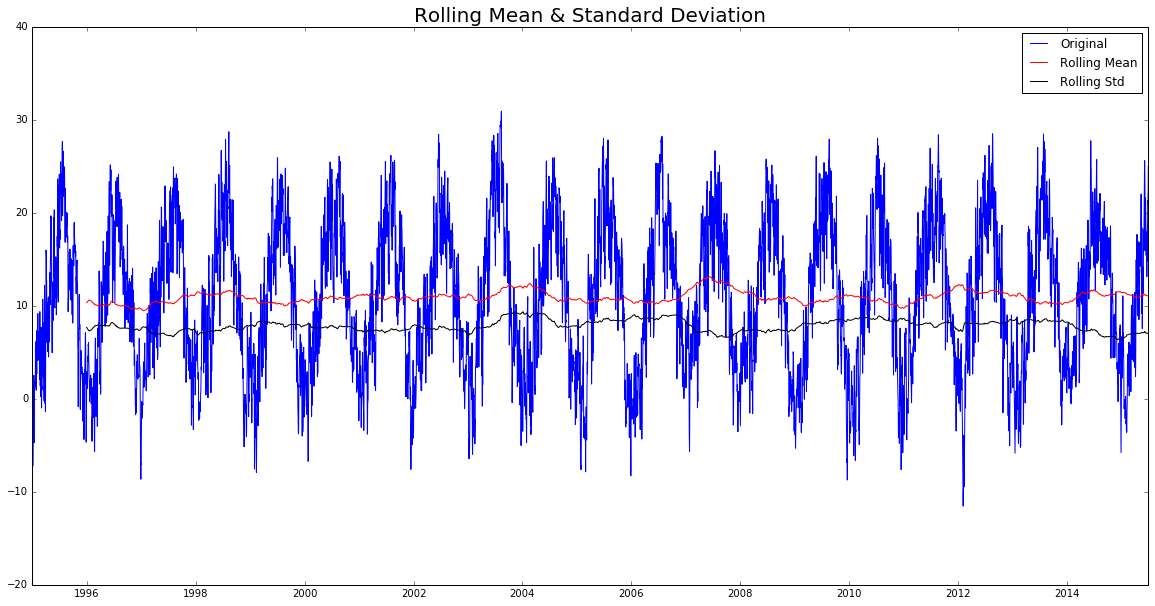

In [32]:
test_stationarity(temperature)

#### The rolling values appear to be varying slightly but there is no specific trend.

In [33]:
#Perform Dickey-Fuller test:
print 'Results of Dickey-Fuller Test:'
dftest = adfuller(temperature['max_temp'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput

Results of Dickey-Fuller Test:
Test Statistic                   -5.467788
p-value                           0.000002
#Lags Used                       21.000000
Number of Observations Used    7464.000000
Critical Value (5%)              -2.861927
Critical Value (1%)              -3.431226
Critical Value (10%)             -2.566976
dtype: float64


####  The DF test statistic is significantly smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series.

#### If trend exists in the data, one can transform the data by taking a log, square root, etc. Some of most commonly used techniques to estimate the trend are:
- Aggregation: taking average for a time period (365 days)
- Smoothing - taking rolling averages
- Polynomial Fitting - fit a regression model

#### After estimating the trend, remove it from the series to detrend.

#### For time series with high seasonality, two more methods can be used:
- Differenceing - taking the difference with a particular time lag
- Decomposition - modeling both trend and seasonality and removing them from the model


## 2.3 removing seasonality

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=365,center=False).mean()
C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=365,center=False).std()


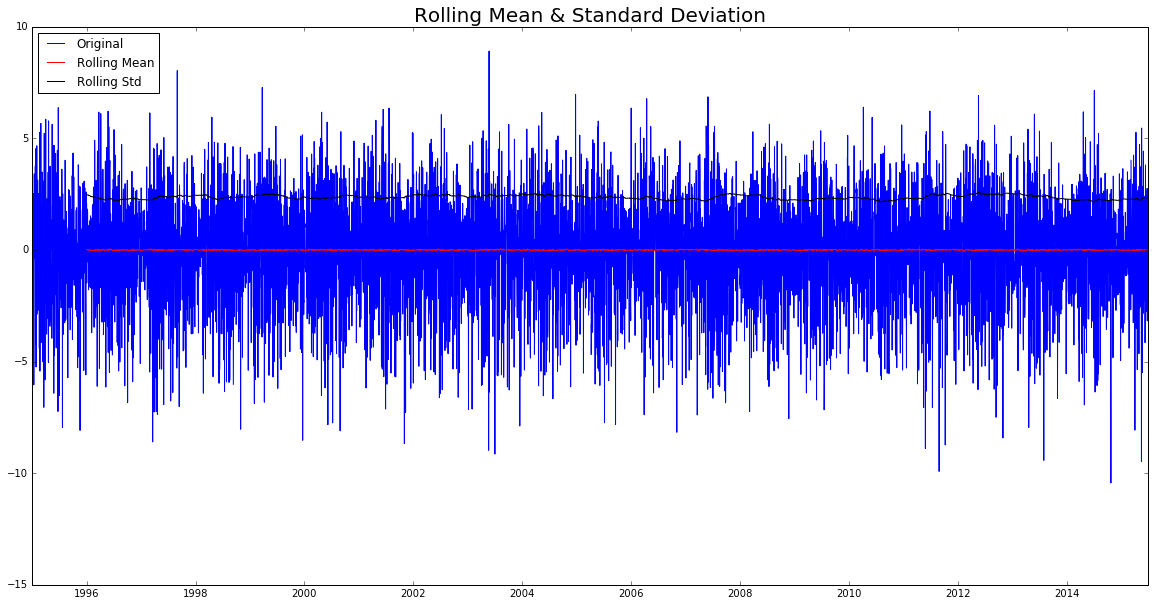

In [34]:
ts_diff = temperature - temperature.shift()
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

#### Taking the difference have removed the seasonality.

#### I've also tried the decomposition method, but there is a known bug for daily data: https://github.com/statsmodels/statsmodels/issues/2398

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(temperature)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-94-899cf930b98f> in <module>()
      1 from statsmodels.tsa.seasonal import seasonal_decompose
----> 2 decomposition = seasonal_decompose(temperature)
      3 
      4 trend = decomposition.trend
      5 seasonal = decomposition.seasonal

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\statsmodels\tsa\seasonal.pyc in seasonal_decompose(x, model, filt, freq)
     68 
     69     if pfreq is not None:
---> 70         pfreq = freq_to_period(pfreq)
     71         if freq and pfreq != freq:
     72             raise ValueError("Inferred frequency of index and frequency "

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.pyc in freq_to_period(freq)
    655     else:  # pragma : no cover
    656         raise ValueError("freq {} not understood. Please report if you "
--> 657                          "think this in error.".format(freq))
    658 
    659 

ValueError: freq D not understood. Please report if you think this in error.


# 3. Forecast model

### To forecast, I use Auto-Regressive Integrated Moving Averages (ARIMA) model. There are three parameters for this model:
1. Number of AR term p: lags of dependent variable.
2. Number of MA term q: lagged forcast errors.
3. Number of differences d: degree of differencing. I've already taken a difference above, so I can either pass ts_diff and set d=0 or use the original variable and set d=1.

### To choose proper value of p and q, I use Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.
1. ACF: a plot of total correlation between different lag. For an MA(q) model, there is no correlation between x(t) and x(t-q-1). Hence, ACF cuts off at qth lag. In other words, the cut off point in ACF indicates q.
2. PACF: a plot of partial correlation of each lag. For an AR(p) model, if we exclude the effect of first p lags,i.e. x(t-1), x(t-2), ... x(t-p), the p+1 lag x(t-p-1) is independent of x(t). Hence the PACF drop sharply after pth lag. In other words, the cut off point in PACF indicates p.

#### Here, I choose to forecast using the original series instead of using the differenced one because the result from the latter is not good. See Appendix.

In [35]:
#ACF and PACF plots:
lag_acf = acf(temperature, nlags=20)
lag_pacf = pacf(temperature, method='ols', nlags=20)

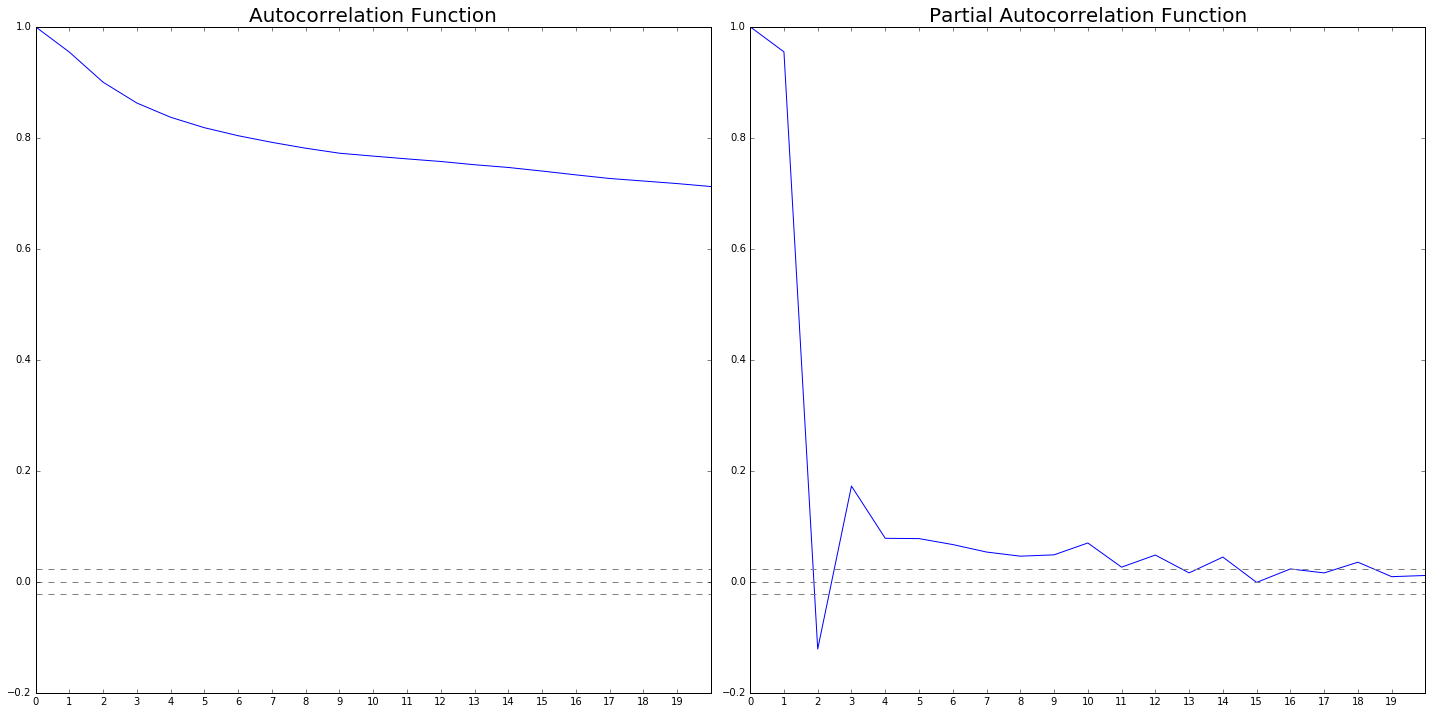

In [36]:
#Plot ACF: 
plt.figure(figsize=(20, 10))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temperature)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temperature)),linestyle='--',color='gray')
plt.xticks(np.arange(0,20,1))
plt.title('Autocorrelation Function', fontsize=20)

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temperature)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temperature)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function', fontsize=20)
plt.xticks(np.arange(0,20,1))
plt.tight_layout()

#### In the above plot, the dotted lines are the 95% confidence intervals. p = 2 and q = 0.

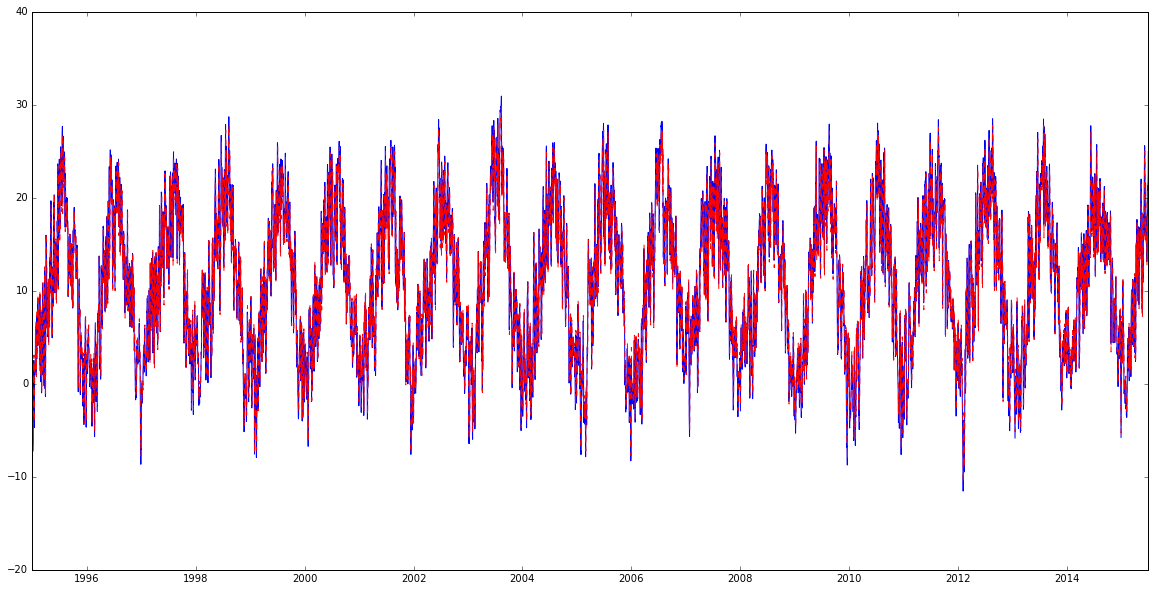

In [37]:
model = ARIMA(temperature, order=(2, 0, 0))
results_AR = model.fit(disp=-1)
plt.figure(figsize=(20, 10))
plt.plot(temperature)
plt.plot(results_AR.fittedvalues, linestyle='--', color='red')

In [38]:
temperature['fit'] = results_AR.fittedvalues
temperature['diff%'] = (temperature['max_temp'] - temperature.fit)/abs(temperature.fit)
outliers_hot = temperature[temperature['diff%']>0.4]

In [39]:
temperature.head()

,max_temp,fit,diff%
1995-01-01,0.479861,10.883372,-0.955909
1995-01-02,-4.636667,0.949129,-5.885182
1995-01-03,-4.647083,-4.472021,-0.039146
1995-01-04,-7.256805,-3.862894,-0.878593
1995-01-05,-6.550694,-6.655745,0.015783


In [54]:
float(len(outliers_hot))/len(temperature)

0.09617953513224686

In [40]:
outliers_hot.to_csv('outliers_hot.csv')

# Appendix
Forecast using differenced time series.

In [41]:
#ACF and PACF plots:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, method='ols', nlags=20)

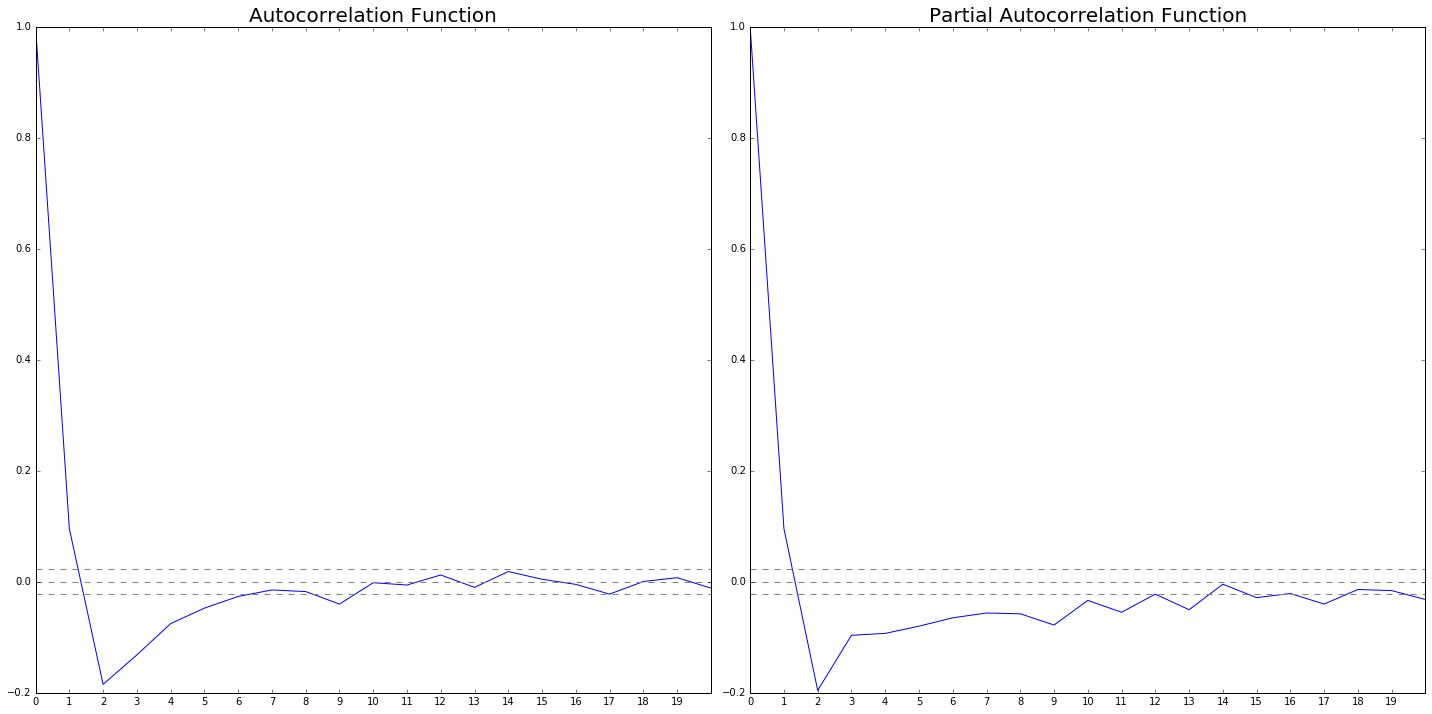

In [42]:
#Plot ACF: 
plt.figure(figsize=(20, 10))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temperature)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temperature)),linestyle='--',color='gray')
plt.xticks(np.arange(0,20,1))
plt.title('Autocorrelation Function', fontsize=20)

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(temperature)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(temperature)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function', fontsize=20)
plt.xticks(np.arange(0,20,1))
plt.tight_layout()

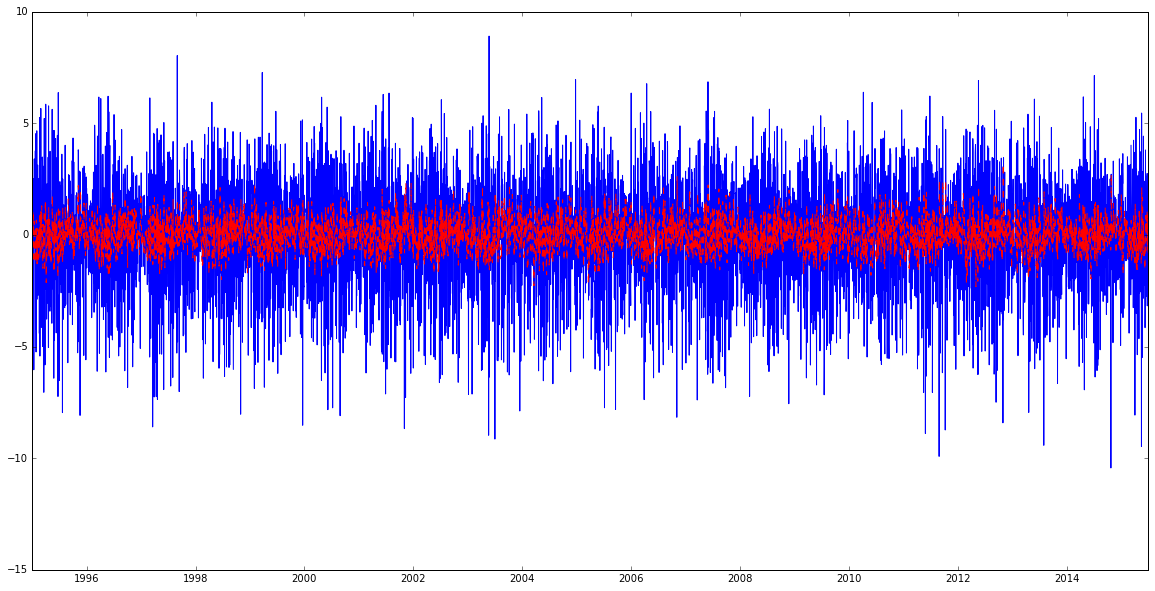

In [43]:
model = ARIMA(ts_diff, order=(2, 0, 2))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20, 10))
plt.plot(ts_diff)
plt.plot(results_ARIMA.fittedvalues, linestyle='--', color='red')

### Scale back 

In [44]:
pred_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
pred_diff_cumsum = pred_diff.cumsum()
predictions = pd.Series(temperature.ix[0], index=temperature.index)
predictions = predictions.add(pred_diff_cumsum, fill_value=0)

In [45]:
predictions.head()

1995-01-01         NaN
1995-01-02    0.002955
1995-01-03   -0.485352
1995-01-04    0.513657
1995-01-05    0.765164
dtype: float64

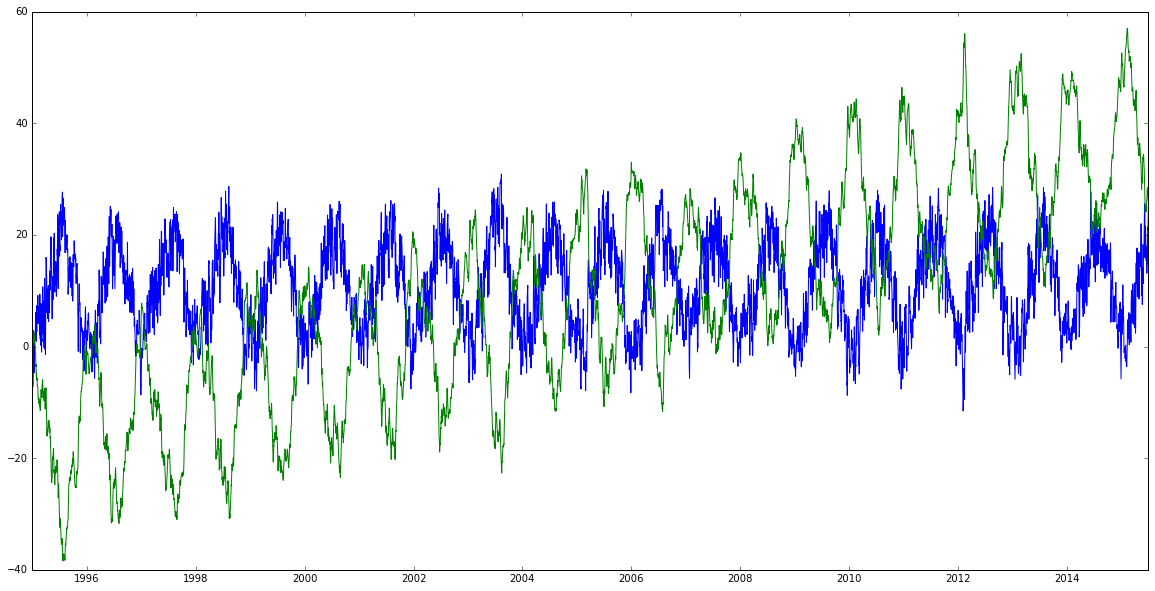

In [50]:
plt.figure(figsize=(20, 10))
plt.plot(temperature['max_temp'])
plt.plot(predictions)